In [113]:
from PushTEnv import PushTEnv
from data import PushTStateDataset, unnormalize_data, normalize_data
import torch as t
import numpy as np
from conditional_unet1d import ConditionalUnet1D
from transformer_for_diffusion import TransformerForDiffusion
from diffusers.training_utils import EMAModel
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers.optimization import get_scheduler
from tqdm.notebook import tqdm
import collections
import matplotlib.pyplot as plt

In [95]:
env = PushTEnv()

obs_dim = 5
action_dim = 2

In [ ]:
# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr"

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTStateDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)

stats = dataset.stats

# create dataloader
dataloader = t.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True 
)

In [ ]:
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)
noise_pred_net = noise_pred_net.to("cuda")

ema = EMAModel(
    model=noise_pred_net,
    power=0.75)

In [124]:
# noise_scheduler = DDPMScheduler(
#     num_train_timesteps=100,
#     beta_schedule='squaredcos_cap_v2',
#     clip_sample=True,
#     prediction_type='epsilon'
# )
diffusion_timesteps = 100

noise_scheduler = DDPMScheduler(
    num_train_timesteps=diffusion_timesteps,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=True,
    prediction_type='epsilon'
)

In [125]:
num_epochs = 100

optimizer = t.optim.AdamW(
    params=noise_pred_net.parameters(), 
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

In [126]:
losses = []
for epoch in (e_iter := tqdm(range(num_epochs))):
    for batch in (b_iter := tqdm(dataloader, leave=False)):
        actions = batch["action"].to("cuda")
        obs = batch["obs"].to("cuda")
        context = obs.reshape((obs.shape[0], -1))
        
        noise = t.randn(actions.shape, device="cuda")
        
        timesteps = t.randint(0, diffusion_timesteps, (len(actions),), device="cuda")
        noised_action = noise_scheduler.add_noise(actions, noise, timesteps)
        noise_pred = noise_pred_net(noised_action, timesteps, global_cond=context)
        
        loss = t.nn.functional.mse_loss(noise_pred, noise)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()
        ema.step(noise_pred_net)
        b_iter.set_postfix({"Loss": loss.item()})
        losses.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

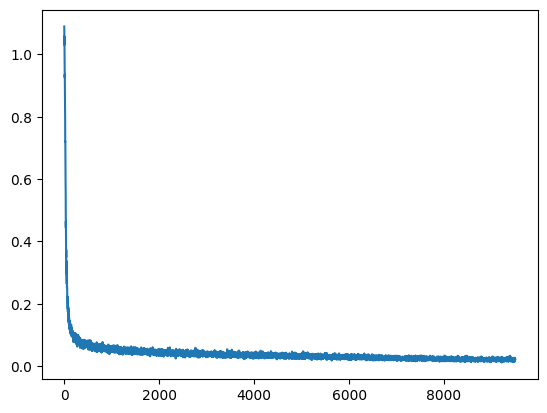

In [134]:
import matplotlib.pyplot as plt

plt.plot(losses)

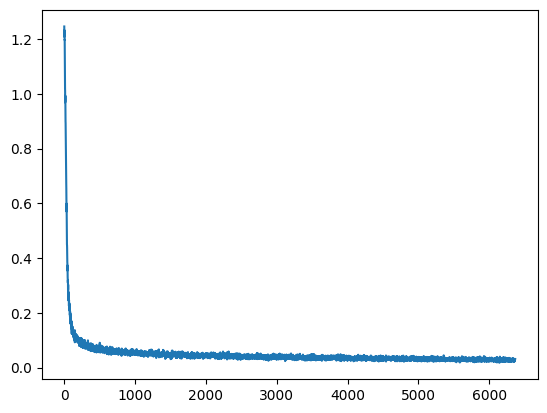

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
ema_noise_pred_net = ema.averaged_model

In [121]:
print(obs)

[258.71621409 224.51130697 265.74124653 268.24221971   1.06834073]


In [135]:
# limit enviornment interaction to 200 steps before termination
max_steps = 500
env = PushTEnv()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(100000)

# get first observation
obs = env.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0

with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
    while not done:
        B = 1
        # stack the last obs_horizon (2) number of observations
        obs_seq = np.stack(obs_deque)
        # normalize observation
        nobs = normalize_data(obs_seq, stats=stats['obs'])
        # device transfer
        nobs = t.from_numpy(nobs).to("cuda", dtype=t.float32)

        # infer action
        with t.no_grad():
            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            noisy_action = t.randn(
                (B, pred_horizon, action_dim), device="cuda")
            naction = noisy_action
            
            # init scheduler
            noise_scheduler.set_timesteps(diffusion_timesteps)

            for k in noise_scheduler.timesteps:
                # predict noise
                noise_pred = ema_noise_pred_net(
                    sample=naction, 
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

Eval PushTStateEnv:   0%|          | 0/500 [00:00<?, ?it/s]

Score:  0.9963691085756696


In [136]:
# visualize
from IPython.display import Video
from skvideo.io import vwrite
vwrite('vis.mp4', imgs)

In [138]:
t.save(ema_noise_pred_net, "state_model.pkl")